# Causalnex Tutorial

In [60]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine

## Structure from Domain Knowledge

In [14]:
sm = StructureModel()

In [15]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [16]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


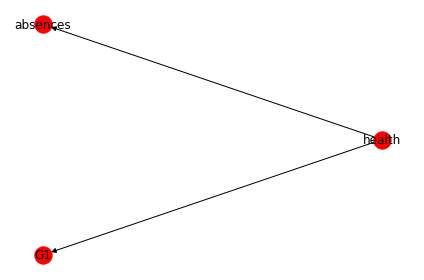

In [17]:
_, _, _ = plot_structure(sm)

## Structure from data

In [18]:
data = pd.read_csv('../../data/student-por.csv', delimiter=';')

In [19]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Dropping "sensitive features such as sex that we do not want to include in our model" per the tutorial. Of course, causality teaches us that dropping the variable does not eliminate its effect or prevent discrimination.

### Preparation

In [20]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


In [21]:
struct_data = data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [22]:
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


### Structure learning

In [24]:
# this takes a minute to run
sm = from_pandas(struct_data)

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


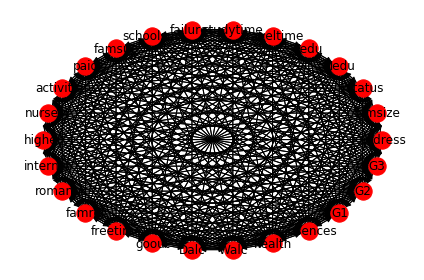

In [25]:
_, _, _ = plot_structure(sm)

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


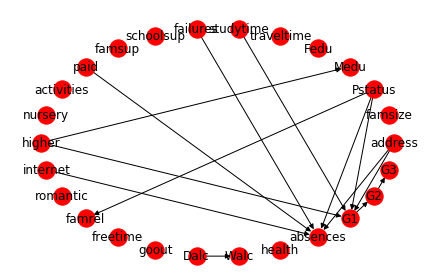

In [26]:
sm.remove_edges_below_threshold(0.8)
_, _, _ = plot_structure(sm)

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


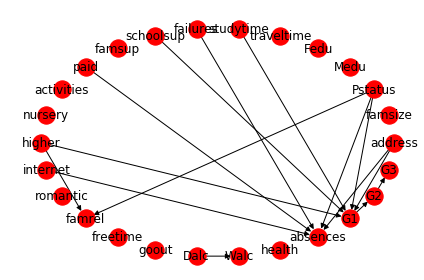

In [27]:
# forbid some edges
sm = from_pandas(
    struct_data,
    tabu_edges=[
        ('higher', 'Medu')
    ],
    w_threshold=0.8)

_, _, _ = plot_structure(sm)

In [28]:
sm.add_edge('failures', 'G1')
sm.remove_edge('Pstatus', 'G1')
sm.remove_edge('address', 'G1')

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


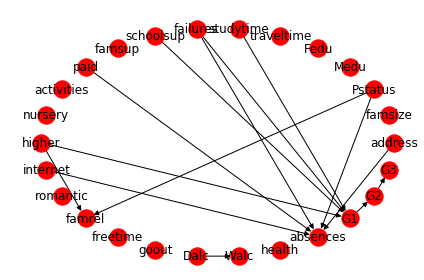

In [29]:
_, _, _ = plot_structure(sm)

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


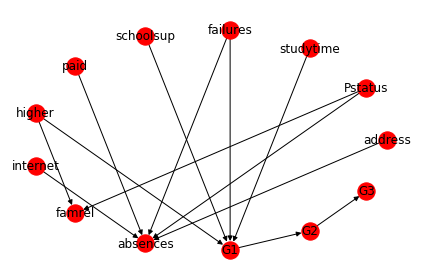

In [30]:
sm = sm.get_largest_subgraph()

_, _, _ = plot_structure(sm)

## Model with Bayesian Network

CausalNex supports only discrete distributions in Baysian networks, so we must discretize continuous features.

### Reduce cardinality of categorical features

In [36]:
discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}
failures_map = {
    v: 'no-failure' if v == [0]
    else 'have-failure'
    for v in data_vals['failures']
}

studytime_map = {
    v: 'short-studytime' if v in [1, 2]
    else 'long-studytime'
    for v in data_vals['studytime']
}

In [37]:
discretised_data['failures'] = discretised_data['failures'].map(failures_map)
discretised_data['studytime'] = discretised_data['studytime'].map(studytime_map)

### Discretize numeric features

In [38]:
discretised_data['absences'] = Discretiser(
    method='fixed', numeric_split_points=[1,10]
).transform(discretised_data['absences'].values)

discretised_data['G1'] = Discretiser(
    method='fixed', numeric_split_points=[10]
).transform(discretised_data['G1'].values)

discretised_data['G2'] = Discretiser(
    method='fixed', numeric_split_points=[10]
).transform(discretised_data['G2'].values)

discretised_data['G3'] = Discretiser(
    method='fixed', numeric_split_points=[10]
).transform(discretised_data['G3'].values)

### Label numeric features

In [40]:
absences_map = {0: 'no-absence', 1: 'low-absence', 2: 'high-absence'}

G_map = {0: 'fail', 1: 'pass'}

discretised_data['absences'] = discretised_data['absences'].map(absences_map)
discretised_data['G1'] = discretised_data['G1'].map(G_map)
discretised_data['G2'] = discretised_data['G2'].map(G_map)
discretised_data['G3'] = discretised_data['G3'].map(G_map)

### Train/test split

In [42]:
train, test = train_test_split(
    discretised_data,
    train_size=0.9, 
    test_size=0.1,
    random_state=7
)

## Fit

In [43]:
bn = BayesianNetwork(sm)

In [44]:
bn = bn.fit_node_states(discretised_data)

In [46]:
bn = bn.fit_cpds(train, method='BayesianEstimator', bayes_prior='K2')

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/pandas/core/generic.py:5069: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/pandas/core/generic.py:5070: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [47]:
bn.cpds['G1']

failures    have-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
fail                0.75        0.806452            0.5            0.75   
pass                0.25        0.193548            0.5            0.25   

failures                                                                 \
higher               yes                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
fail                 0.5        0.612245            0.5            0.75   
pass                 0.5        0.387755            0.5            0.25   

failures      no-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
fail                 0.5        0.612903            0.5             0.5   
pass                 0.5        0.387097            0.5             0.5   

failures                                                                 
higher               yes                                                 
schoolsup             no                            yes                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
fail            0.032967         0.15016       0.111111        0.255814  
pass            0.967033         0.84984       0.888889        0.744186

In [48]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short-studytime
failures         have-failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          low-absence
G2                       fail
G3                       fail
Name: 18, dtype: object

In [52]:
predictions = bn.predict(discretised_data, 'G1')
print('The prediction is "{prediction}"'.format(prediction=predictions.loc[18, 'G1_prediction']))

The prediction is "fail"


In [53]:
print('The ground truth is "{truth}"'.format(truth=discretised_data.loc[18, 'G1']))

The ground truth is "fail"


## Model quality

### Classification report

In [55]:
classification_report(bn, test, 'G1')

,precision,recall,f1-score,support
G1_fail,0.777778,0.583333,0.666667,12
G1_pass,0.910714,0.962264,0.935780,53
macro avg,0.844246,0.772799,0.801223,65
micro avg,0.892308,0.892308,0.892308,65
weighted avg,0.886172,0.892308,0.886097,65


### ROC/AUC

In [61]:
roc, auc = roc_auc(bn, test, 'G1')
print(auc)

0.9181065088757396


## Querying marginals

In [62]:
# refit on all data, not only train
bn = bn.fit_cpds(discretised_data, method='BayesianEstimator', bayes_prior='K2')

/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/pandas/core/generic.py:5069: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/chriswallace/Code/fastforwardlabs/causal-experiments/experiments/causalnex/.venv/lib/python3.7/site-packages/pandas/core/generic.py:5070: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [63]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals['G1']

{'fail': 0.25260687281677224, 'pass': 0.7473931271832277}

In [64]:
discretised_data['G1'].value_counts()

pass    492
fail    157
Name: G1, dtype: int64

In [65]:
marginals_short = ie.query({'studytime': 'short-studytime'})
marginals_long = ie.query({'studytime': 'long-studytime'})
print("Marginal G1 | Short Studtyime", marginals_short["G1"])
print("Marginal G1 | Long Studtyime", marginals_long["G1"])

Marginal G1 | Short Studtyime {'fail': 0.2776556433482524, 'pass': 0.7223443566517477}
Marginal G1 | Long Studtyime {'fail': 0.15504850337837614, 'pass': 0.8449514966216239}


## Do Calculus

In [66]:
print('distribution before intervention:', ie.query()['higher'])
ie.do_intervention('higher', {'yes': 1.0, 'no': 0.0})
print('distribution after intervention:', ie.query()['higher'])

distribution before intervention: {'no': 0.10752688172043011, 'yes': 0.8924731182795698}
distribution after intervention: {'no': 0.0, 'yes': 0.9999999999999998}


In [71]:
ie.reset_do('higher')

In [72]:
print('marginal G1:', ie.query()['G1'])
ie.do_intervention('higher', {'yes': 1.0, 'no': 0.0})
print('updated marginal G1', ie.query()['G1'])

marginal G1: {'fail': 0.25260687281677224, 'pass': 0.7473931271832277}
updated marginal G1 {'fail': 0.20682952942551894, 'pass': 0.7931704705744809}
